In [1]:
# Setup notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import DeterministicProcess

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [2]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

store_sales = pd.read_csv(
    'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

In [3]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=y.columns,
        )

        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid
       
    
    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()

In [4]:
# Target series
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

y = family_sales.loc[:, 'sales']

print(y)

# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=2)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature


print(X_2)

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

family      AUTOMOTIVE  BABY CARE     BEAUTY    BEVERAGES     BOOKS  \
date                                                                  
2017-01-01    0.092593   0.037037   0.055556    74.222221  0.000000   
2017-01-02   11.481482   0.259259  11.648149  6208.055664  0.481481   
2017-01-03    8.296296   0.296296   7.185185  4507.814941  0.814815   
2017-01-04    6.833333   0.333333   6.888889  3911.833252  0.759259   
2017-01-05    6.333333   0.351852   5.925926  3258.796387  0.407407   
...                ...        ...        ...          ...       ...   
2017-08-11    8.166667   0.129630   6.500000  3502.055664  0.000000   
2017-08-12    7.462963   0.055556   6.833333  3376.259277  0.000000   
2017-08-13    8.907408   0.166667   8.018518  3747.296387  0.018519   
2017-08-14    5.407407   0.166667   6.240741  3237.629639  0.000000   
2017-08-15    6.240741   0.148148   6.277778  3162.462891  0.000000   

family      BREAD/BAKERY  CELEBRATION     CLEANING        DAIRY        DELI 

/home/krupenz/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/home/krupenz/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


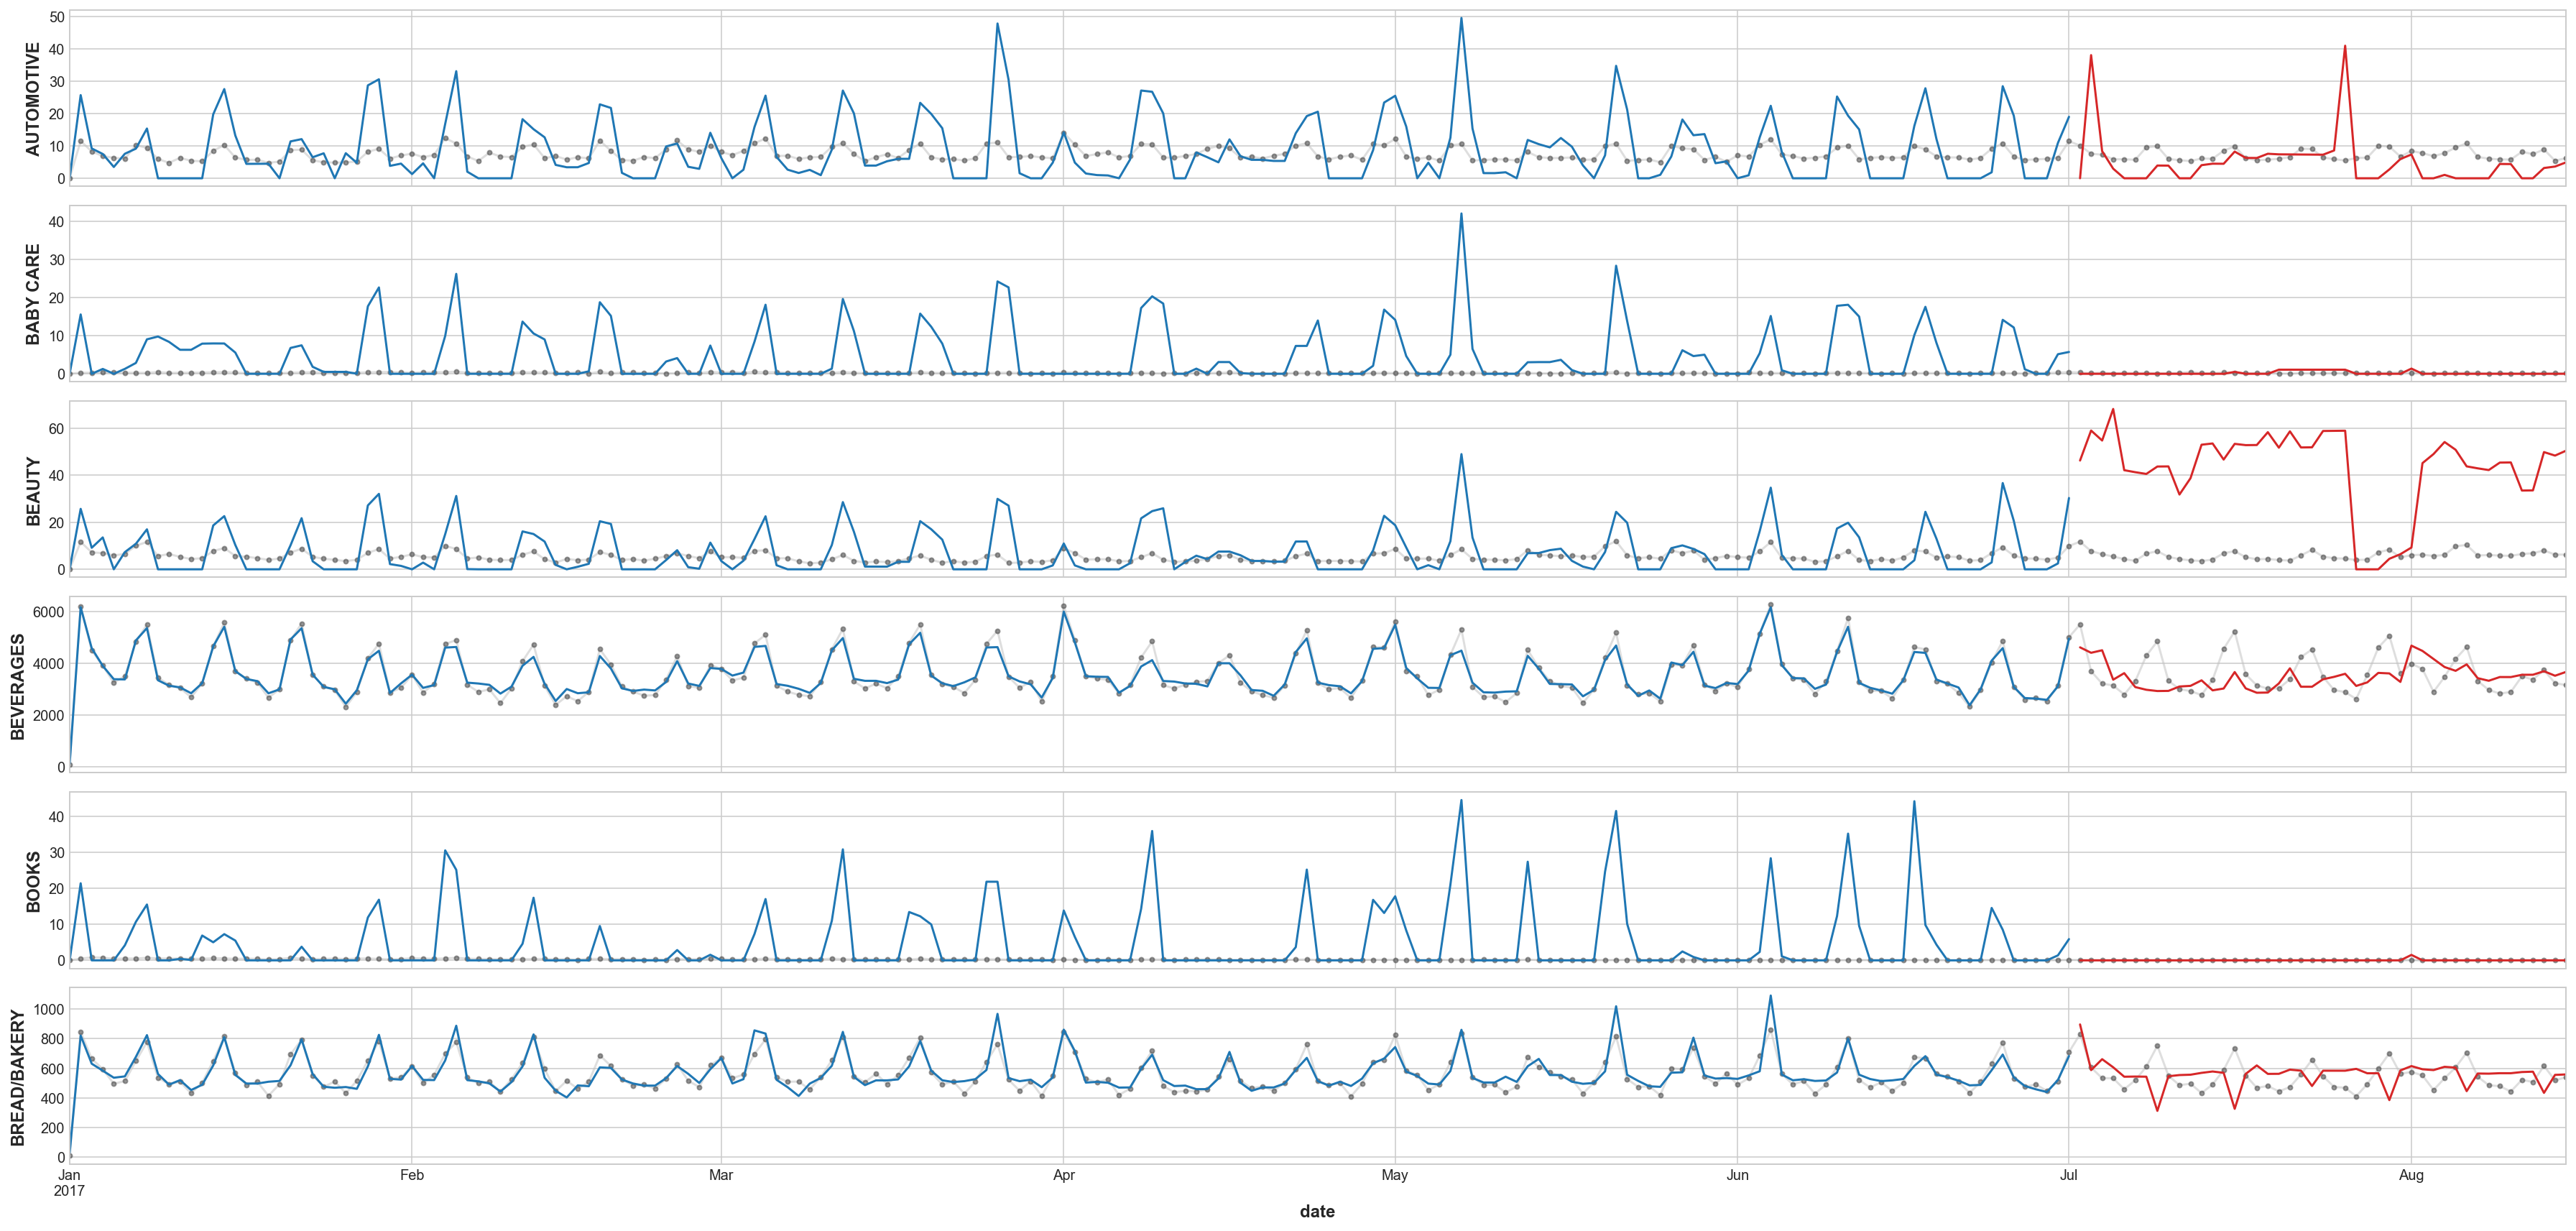

In [5]:
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(25, 12), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)